# Object detection with Faster R-CNN
Faster R-CNN short for "Faster Region-Convolutional Neural Network" is a state-of-the-art object detection architecture of the R-CNN family.

The primary goal of the Faster R-CNN network is to develop a unified architecture that detects objects within an image and also locates the objects precisely in the image.

It combines the benefits of deep learning, convolutional neural networks (CNNs), and region proposal networks(RPNs) into a cohesive network, which significantly improves the speed and accuracy of the model.



---



**Faster R-CNN is composed of two main parts:**


1.   Region Proposal Network (RPN): Proposes candidate regions (possible object locations).
2.  Fast R-CNN (Detection Network): Classifies the proposed regions and refines their bounding boxes.


It is called "Faster" R-CNN because it improves upon earlier R-CNN models by making the region proposal step part of the network itself, rather than relying on a slow external method (like Selective Search).



# Let's move with an implementation of object detection with Faster R-CNN

Install the required libraries and download the images

In [1]:
%%capture
! pip3 install --quiet torch torchvision torchaudio

In [2]:
%%capture
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/DLguys.jpeg
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/watts_photos2758112663727581126637_b5d4d192d4_b.jpeg
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/istockphoto-187786732-612x612.jpeg
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/jeff_hinton.png

In [3]:
#import the learning libraries
import torchvision
from torchvision import  transforms
import torch
from torch import no_grad

#library for getting data from the web
import requests

#libraries for image processing and visualization
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

#Define Auxillary functions

In [4]:
def get_predictions(pred,threshold=0.8,objects=None ):
    """
    It processes the raw output from an object detection model, converts class indices to human-readable labels, and filters out predictions below a threshold.

    Args:

      pred (list of dict): The model's output for one image. It is a list where each element contains information about the different objects.
      threshold: Minimum confidence score to keep a prediction. Default is 0.8
      objects (list of str, optional): A list of class names to retain. If none, all classes are included.

    Returns:
      list of tuples: each tuple contains: class name (str), confidence score (float), and bounding box coordinates (eg., [(x1,y1),(x2,y2)]).

    predicted classes: a list of tuples, where each tuple contains the class name, confidence score, and bounding box coordinates.
    """

    # the zip function pairs the label, score, and box for each detected object e.g, ("person", 0.95, [(x1,y1),(x2,y2)])

    predicted_classes= [(COCO_INSTANCE_CATEGORY_NAMES[i], # converts class indices into class names
                         p,[(box[0], box[1]), (box[2], box[3])])
    for i,p,box in zip(
        list(pred[0]['labels'].numpy()), # contains class indices
        pred[0]['scores'].detach().numpy(), # confidence scores for each detected object
        list(pred[0]['boxes'].detach().numpy()))] # contains bounding box for each detected object
    predicted_classes=[ x for x in predicted_classes if x[1]>threshold ]

    if objects and predicted_classes :
        predicted_classes=[ (name, p, box) for name, p, box in predicted_classes if name in objects ]
    return predicted_classes

In [5]:
def draw_box(predicted_classes, image, rect_th=10, text_size=3, text_th=3):
    """
    Draws rectangular bounding boxes and class labels(with confidence scores) around each detected object on the image.

    Args:
      predicted_classes: list of tuples (label, probability, [pt1, pt2])
        pt1: top-left corner of the bounding box(starting point of the rectangle),
        pt2: bottom-right corner of the bounding box(ending point of the rectangle)
      image(torch.Tensor): The input image is a pytorch tensor in shape (3, H, W) and values in [0, 1].
      rect_th: thickness of the bounding box lines. Default is 10.
      text_size: font scale for label text. Default is 3.
      text_th: thickness of the label text. Default is 3.

    Returns:
      None. Displays the image with bounding boxes and labels using matplotlib.
    """
    img = (np.clip(cv2.cvtColor(np.clip(image.numpy().transpose((1, 2, 0)), 0, 1),
                                cv2.COLOR_RGB2BGR), 0, 1) * 255).astype(np.uint8).copy()

    for predicted_class in predicted_classes:
        label = predicted_class[0]
        probability = predicted_class[1]
        box = predicted_class[2]

        # Convert points to integer tuples
        pt1 = tuple(map(int, box[0]))
        pt2 = tuple(map(int, box[1]))

        # Draw box and label
        cv2.rectangle(img, pt1, pt2, (0, 255, 0), rect_th)
        cv2.putText(img, f"{label}: {round(probability, 2)}",
                    pt1, cv2.FONT_HERSHEY_SIMPLEX, text_size,
                    (0, 255, 0), thickness=text_th)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Optional: removes axis
    plt.show()

    del img
    del image


In [6]:
#speed up code by freeing up memory
def save_RAM(image_=False):
    global image, img, pred
    torch.cuda.empty_cache()
    del(img)
    del(pred)
    if image_:
        image.close()
        del(image)

#Load Pre-trained Faster R-CNN


In [7]:
model_ = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_.eval()

for name, param in model_.named_parameters():
    param.requires_grad = False
print("DONE")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 327MB/s]


DONE


In [8]:
# the function calls Faster R-CNN  model_  but saves RAM:
def model(x):
    with torch.no_grad():
        yhat = model_(x)
    return yhat

In [9]:
# COCO labels
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
len(COCO_INSTANCE_CATEGORY_NAMES)

91

#Object Localization
In Object Localization we locate the presence of objects in an image and indicate the location with a bounding box.

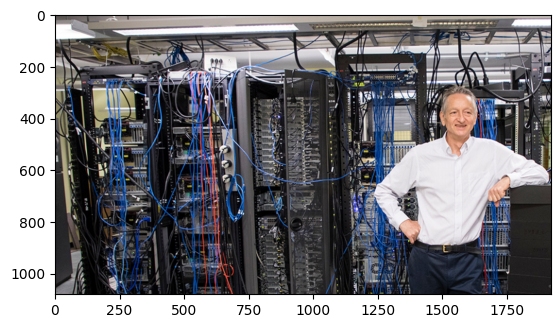

In [10]:
img_path='jeff_hinton.png'
half = 0.5
image = Image.open(img_path)

image.resize( [int(half * s) for s in image.size] )

plt.imshow(image)
plt.show()

In [11]:
# create a transform object to convert the image to a tensor.
transform = transforms.Compose([transforms.ToTensor()])

In [12]:
#convert the image to a tensor
img = transform(image)

Now, let's make a prediction.

The output is a dictionary with several predicted classes, the probability of belonging to that class and the coordinates of the bounding box corresponding to that class.

In [13]:
pred = model([img])

There are 35  different class predictions, ordered by likelihood(probability)  scores for potential objects.


In [14]:
pred[0]['labels']

tensor([ 1, 15, 84,  2, 35, 84, 62,  2,  7, 84, 82, 84, 35, 84,  2, 35, 15, 42,
         2, 82, 62, 84, 62, 84,  7,  2, 84,  7,  2,  9, 84, 84,  2, 84,  2])

Let's view the probability of each class.


In [15]:
pred[0]['scores']

tensor([0.9995, 0.3495, 0.2695, 0.2556, 0.2466, 0.1929, 0.1861, 0.1767, 0.1593,
        0.1528, 0.1484, 0.1392, 0.1295, 0.1290, 0.1249, 0.1208, 0.1094, 0.1026,
        0.1023, 0.1019, 0.0846, 0.0827, 0.0826, 0.0794, 0.0785, 0.0738, 0.0735,
        0.0713, 0.0669, 0.0622, 0.0595, 0.0578, 0.0575, 0.0553, 0.0520])

The class number corresponds to the index of the list with the corresponding category name

In [16]:
index=pred[0]['labels'][0].item()
COCO_INSTANCE_CATEGORY_NAMES[index]

'person'

The coordinates of the bounding box:


In [17]:
bounding_box=pred[0]['boxes'][0].tolist()
bounding_box

[1223.168701171875, 301.25, 1909.1724853515625, 1076.63720703125]

These components correspond to the top-left corner and bottom-right corner of the rectangle,more precisely :

top (t),left (l),bottom(b),right (r)

Let's round them.

In [18]:
t,l,r,b=[round(x) for x in bounding_box]

Now, convert the tensor to an open CV array and plot an image with the box:


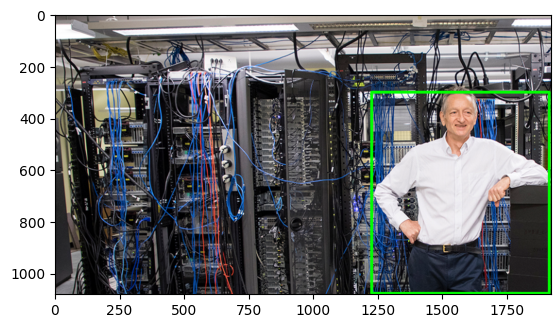

In [19]:
img_plot=(np.clip(cv2.cvtColor(np.clip(img.numpy().transpose((1, 2, 0)),0,1), cv2.COLOR_RGB2BGR),0,1)*255).astype(np.uint8)
cv2.rectangle(img_plot,(t,l),(r,b),(0, 255, 0), 10) # Draw Rectangle with the coordinates
plt.imshow(cv2.cvtColor(img_plot, cv2.COLOR_BGR2RGB))
plt.show()
del img_plot, t, l, r, b

Now, we can localize objects.

We do this using the function get_predictions.

The input is the predictions pred and the objects required to localize .

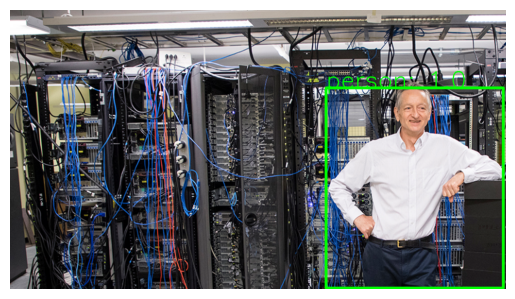

In [20]:
pred_class=get_predictions(pred,objects="person")
draw_box(pred_class, img)
del pred_class

We can set a desired threshold .

Here we set the threshold 1 i.e 100% probability.

In [21]:
get_predictions(pred,threshold=1,objects="person")

[]

We did not get any output as the likelihood is not 100%.

Let's try a threshold of 0.98 and use the function draw_box to draw the box and plot the class.

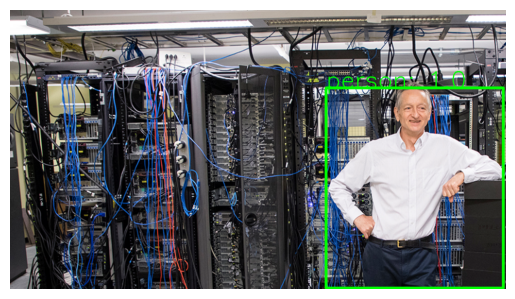

In [22]:
pred_thresh=get_predictions(pred,threshold=0.98,objects="person")
draw_box(pred_thresh,img)
del pred_thresh

In [23]:
#delete objects to save memory, we can run this after every cell
save_RAM(image_=True)

We can locate multiple objects, consider the following image, we can detect the people in the image.

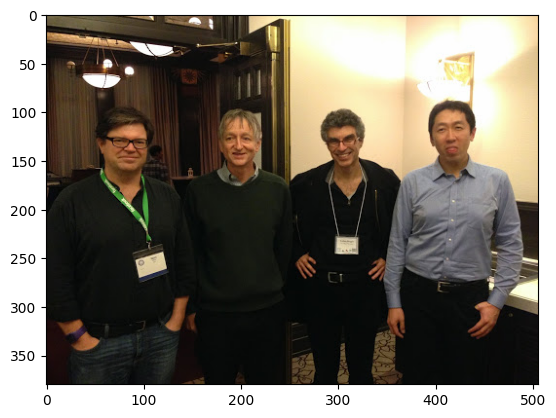

In [24]:
img_path='DLguys.jpeg'
image = Image.open(img_path)
image.resize([int(half * s) for s in image.size])
plt.imshow(np.array(image))
plt.show()

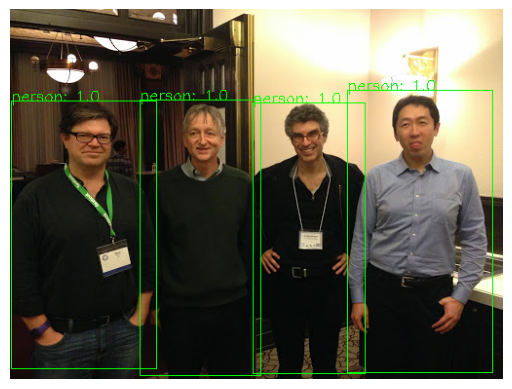

In [25]:
img = transform(image)
pred = model([img])
pred_thresh=get_predictions(pred,threshold=0.8,)
draw_box(pred_thresh,img,rect_th= 1,text_size= 0.5,text_th=1)
del pred_thresh

If we set the threshold too low, then it will detect objects that are not there.

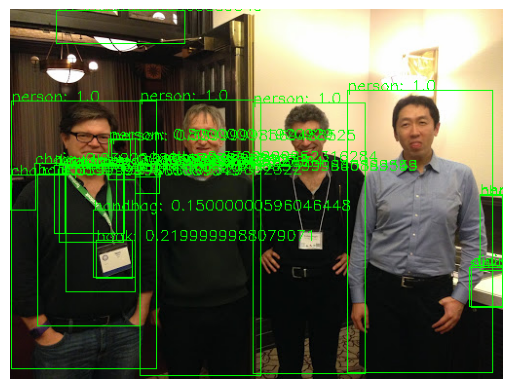

In [26]:
pred_thresh=get_predictions(pred,threshold=0.01)
draw_box(pred_thresh,img,rect_th= 1,text_size= 0.5,text_th=1)
del pred_thresh

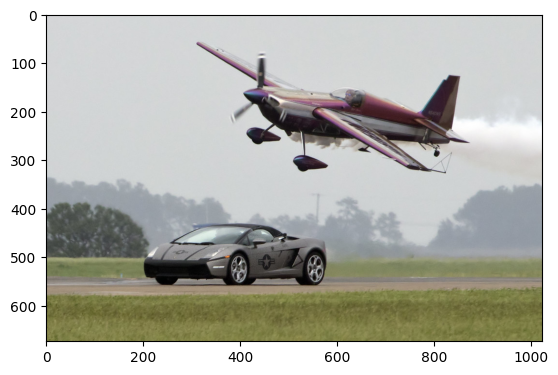

In [27]:
img_path='watts_photos2758112663727581126637_b5d4d192d4_b.jpeg'
image = Image.open(img_path)
image.resize( [int(half * s) for s in image.size] )
plt.imshow(np.array(image))
plt.show()
del img_path

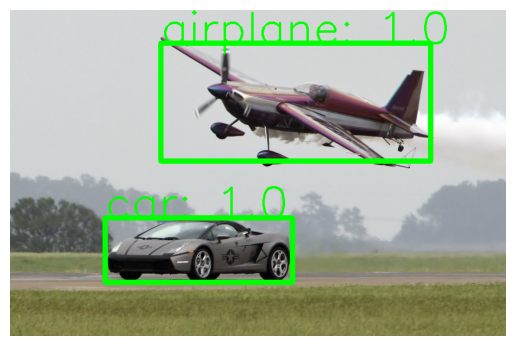

In [28]:
img = transform(image)
pred = model([img])
pred_thresh=get_predictions(pred,threshold=0.997)
draw_box(pred_thresh,img)
del pred_thresh